In [1]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss
from mpl_toolkits.axes_grid1 import make_axes_locatable


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


(-0.5, 649.5, 434.5, -0.5)

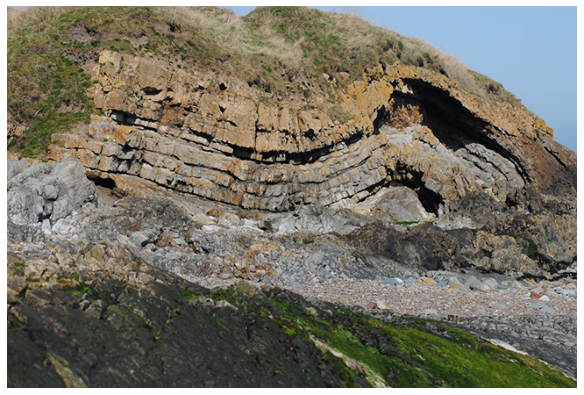

In [2]:
# Load and plot outcrop image
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8, 8))

im = Image.open('outcrop.jpg')
ax.imshow(im)
ax.axis('off')

(-0.5, 649.5, 434.5, -0.5)

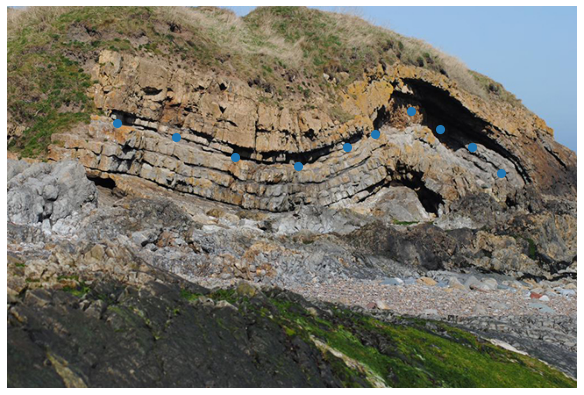

In [3]:
# Data
df = pd.DataFrame(columns=['x', 'z', 'yrr', 's'])

width = 650
height = 435
x = np.array([125, 192, 259, 331, 387, 419, 460, 493, 530, 563])
z = np.array([133, 149, 171, 181, 160, 145, 119, 139, 160, 190])
yrr = np.array([3, 3, 3, 3, 3, 4, 7, 5, 4, 3])


df['x'] = x
df['z'] = z

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8, 8))

ax.imshow(im)
ax.plot(x, z, 'o')
ax.plot([312], [177], '+', c='red')
ax.axis('off')

In [4]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [5]:
geo_model_extent_1 = [0,650,0,435,0,435]
section_1 = {
    'p1': [0, 200],
    'p2': [650, 200],
    'resolution': [650, 435]
}

series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[1] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

surface_points_original_df_1 = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'param1'])
surface_points_original_df_1.X = x 
surface_points_original_df_1.Y = 200
surface_points_original_df_1.Z = z
surface_points_original_df_1.surface = 'rock1'
surface_points_original_df_1['param1'] = yrr

orientations_original_df_1 = pd.read_csv('./data/orientation_outcrop.csv')
orientations_original_df_1

,X,Y,Z,azimuth,dip,polarity,formation
0,312,200,177,90,0,1,rock1


In [6]:
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


In [7]:
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.


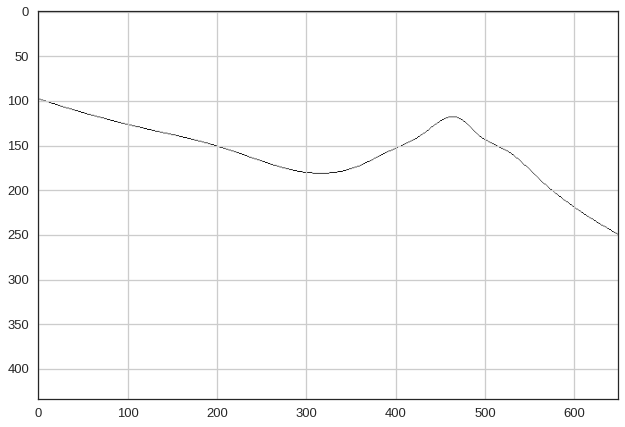

In [8]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
# plot for sanity check
fig, ax1, = plt.subplots(1, 1)
ax1.imshow(Bx['0-1'])
ax1.grid()
plt.show()

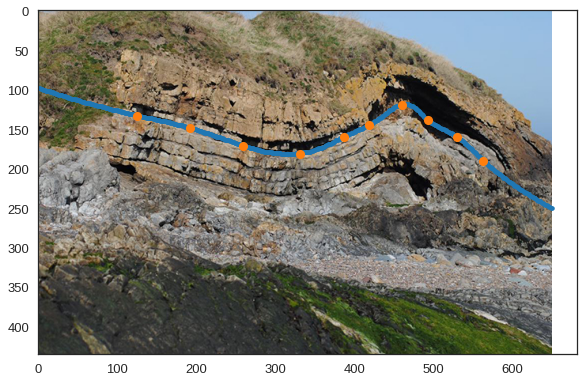

In [9]:
extent = { 'z_min': 0, 'z_max': 435 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8, 8))

ax.imshow(im)
ax.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
ax.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    'o'
)

In [10]:
mapping_object = real_setup.creat_mapping_object(
    series_df=series_df_1,
    surfaces_df=surfaces_df_1
)

In [11]:
# UQ
sp = copy.deepcopy(surface_points_original_df_1)
list_section_data = []
lst_boolen_tops_dicts = {}
n = 10
Bxs = []

for i in range(n):
    
        sp.Z = ss.norm.rvs(
            surface_points_original_df_1['Z'].values,
            surface_points_original_df_1['param1'].values
        )
        geo_model.set_surface_points(sp, update_surfaces=False)
        gp.map_series_to_surfaces(
            geo_model=geo_model,
            mapping_object=mapping_object
        )
        geo_model.update_to_interpolator()
        try:
            gp.compute_model(model=geo_model)
            Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
            Bxs.append(Bx['0-1'])
            tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)
            #fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8, 8))
            #ax.imshow(im)
            #ax.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
            #ax.plot(
            #    geo_model.surface_points.df['X'],
            #    geo_model.surface_points.df['Z'],
            #    'o'
            #)
            #plt.show()
        except ValueError as err:
            print('ValueError')

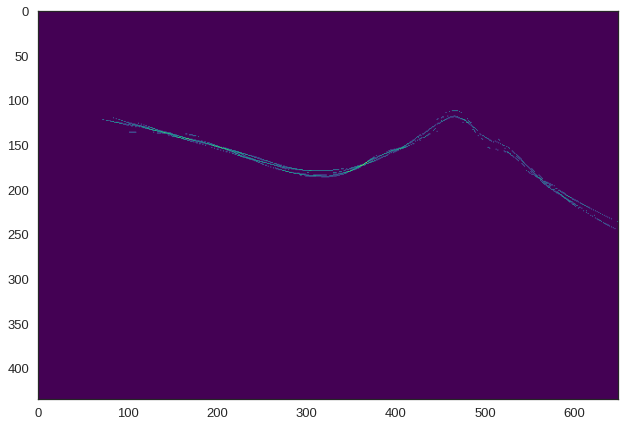

In [12]:
stack = np.dstack(Bxs).astype(int)
prob = stack / n
ie = ss.entropy(prob, axis=2)
mapi = np.nan_to_num(ie)
plt.imshow(mapi, cmap='viridis')

In [13]:
# UQ
sp = copy.deepcopy(surface_points_original_df_1)
list_section_data = []
lst_boolen_tops_dicts = {}
n = 2

for i in range(n):
    
        sp.Z = ss.norm.rvs(
            surface_points_original_df_1['Z'].values,
            surface_points_original_df_1['param1'].values
        )
        geo_model.set_surface_points(sp, update_surfaces=False)
        gp.map_series_to_surfaces(
            geo_model=geo_model,
            mapping_object=mapping_object
        )
        geo_model.update_to_interpolator()
        try:
            gp.compute_model(model=geo_model)
            list_section_data.append(geo_model
                                     .solutions
                                     .sections[0][0]
                                     .reshape(section_1['resolution'])
                                     )            
        except ValueError as err:
            print('ValueError')

In [14]:
section_data_stack = np.round(np.dstack(list_section_data))
lithology_ids = np.unique(section_data_stack)
count_array = np.empty((
    section_1['resolution'][0],
    section_1['resolution'][1],
    len(lithology_ids)))
for index, lithology in enumerate(lithology_ids):
    count_array[:, :, index] = np.sum((
        section_data_stack == lithology).astype(int), axis=2)
probability_array = count_array / n
ie = ss.entropy(probability_array, axis=2)

In [ ]:
# UQ
sp = copy.deepcopy(surface_points_original_df_1)
list_section_data = []
lst_boolen_tops_dicts = {}
n = 100
sps_x = []
sps_z = []
Bxs = []

for i in range(n):
    
        sp.Z = ss.norm.rvs(
            surface_points_original_df_1['Z'].values,
            surface_points_original_df_1['param1'].values
        )
        geo_model.set_surface_points(sp, update_surfaces=False)
        gp.map_series_to_surfaces(
            geo_model=geo_model,
            mapping_object=mapping_object
        )
        geo_model.update_to_interpolator()
        try:
            gp.compute_model(model=geo_model)
            Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
            tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)
            sps_x.append(geo_model.surface_points.df['X'])
            sps_z.append(geo_model.surface_points.df['Z'])
            Bxs.append(Bx['0-1'])
        except ValueError as err:
            print('ValueError')

In [ ]:
A = np.zeros(section_1['resolution'])
for i in range(n):
    
    A.T[1:,:] + [Bxs[i]]
    
plt.imshow(A.T)

In [ ]:
A = np.zeros(section_1['resolution'])
Bxss = []

for i in range(n):
    
    Bxss.append(Bxs[i].astype(int))
    
stack = np.dstack(Bxss)
stack_sum = np.sum(stack, axis=2)

In [ ]:
#plt.imshow(stack_sum)

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8, 8))

ax.imshow(im)
ax.plot(x, z, 'o')
ax.plot([312], [177], '+', c='red')
ax.imshow(stack_sum, alpha=0.5, cmap='viridis')
ax.axis('off')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8, 8))

alphas = np.ones(stack_sum.shape)
alphas[stack_sum == 0] = 0 

ax.imshow(im)
ax.plot(x, z, 'o')
ax.plot([312], [177], '+', c='red')
ax.imshow(stack_sum, alpha=alphas, cmap='viridis')
ax.axis('off')